# Bayesian Dynamic TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [5]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   island_ids                1900 non-null   int64  
 1   years                     1900 non-null   int64  
 2   region_codes              1900 non-null   object 
 3   prefecture_codes          1900 non-null   int64  
 4   populations               1697 non-null   float64
 5   treatment_group           1900 non-null   int64  
 6   treatment_group_mainland  1900 non-null   int64  
 7   year_bridges_opened       1900 non-null   int64  
 8   after_treated             1900 non-null   int64  
 9   year_connect_mainland     1900 non-null   int64  
 10  after_treated_mainland    1900 non-null   int64  
 11  income                    1401 non-null   float64
 12  area_km2                  1900 non-null   float64
 13  distance_m                1900 non-null   float64
 14  elementa

## Dynamic TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{l \in L} \delta_l \mathbf{1}[t - k_i = l] + \epsilon_{it}
$$

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


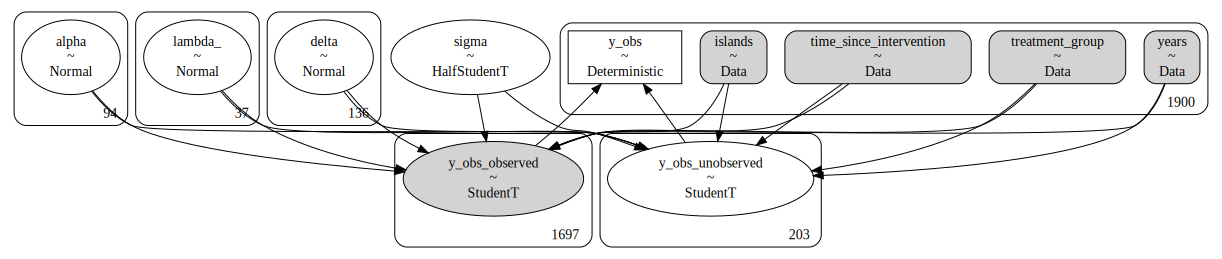

In [32]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    alpha = pm.Normal('alpha', mu=0, sigma=100, shape=len(df['island_ids'].unique()))
    lambda_ = pm.Normal('lambda_', mu=0, sigma=100, shape=len(df['years'].unique()))
    delta = pm.Normal('delta', mu=0, sigma=100, shape=len(df['time_since_intervention'].unique()))
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta[time_since_intervention] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe)

In [26]:
with dynamic_twfe:
    trace_dynamic_twfe = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )

ValueError: operands could not be broadcast together with shapes (136,) (1900,) 
Apply node that caused the error: Mul(AdvancedSubtensor.0, treatment_group)
Toposort index: 8
Inputs types: [TensorType(float64, shape=(None,)), TensorType(int32, shape=(None,))]
Inputs shapes: [(136,), (1900,)]
Inputs strides: [(8,), (4,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Add(AdvancedSubtensor.0, AdvancedSubtensor.0, Mul.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    result = self._run_cell(
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    result = runner(coro)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3944/4263061750.py", line 20, in <module>
    mu = alpha[islands] + lambda_[years] + delta[time_since_intervention] * treatment_group

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [33]:
az.summary(trace_dynamic_twfe, var_names=['delta', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta[0],168.244,52.598,68.994,271.152,1.016,0.741,2684.0,1675.0,1.0
delta[1],96.754,50.185,5.054,199.226,1.004,0.844,2525.0,1408.0,1.0
delta[2],77.774,45.199,-8.397,166.929,0.985,0.734,2096.0,1688.0,1.0
delta[3],30.947,48.793,-62.811,129.135,0.850,0.944,3280.0,1662.0,1.0
delta[4],34.132,53.396,-71.024,135.875,1.034,1.165,2846.0,1411.0,1.0
...,...,...,...,...,...,...,...,...,...
delta[132],128.752,50.802,33.297,230.075,0.980,0.764,2703.0,1522.0,1.0
delta[133],111.274,43.894,27.507,196.781,0.935,0.675,2212.0,1761.0,1.0
delta[134],64.196,51.089,-41.079,154.188,0.832,0.762,3658.0,1519.0,1.0
delta[135],121.848,51.913,26.808,226.692,0.967,0.715,2914.0,1433.0,1.0


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'y_obs_unobserved'}>,
        <Axes: title={'center': 'y_obs_unobserved'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_obs'}>,
        <Axes: title={'center': 'y_obs'}>]], dtype=object)

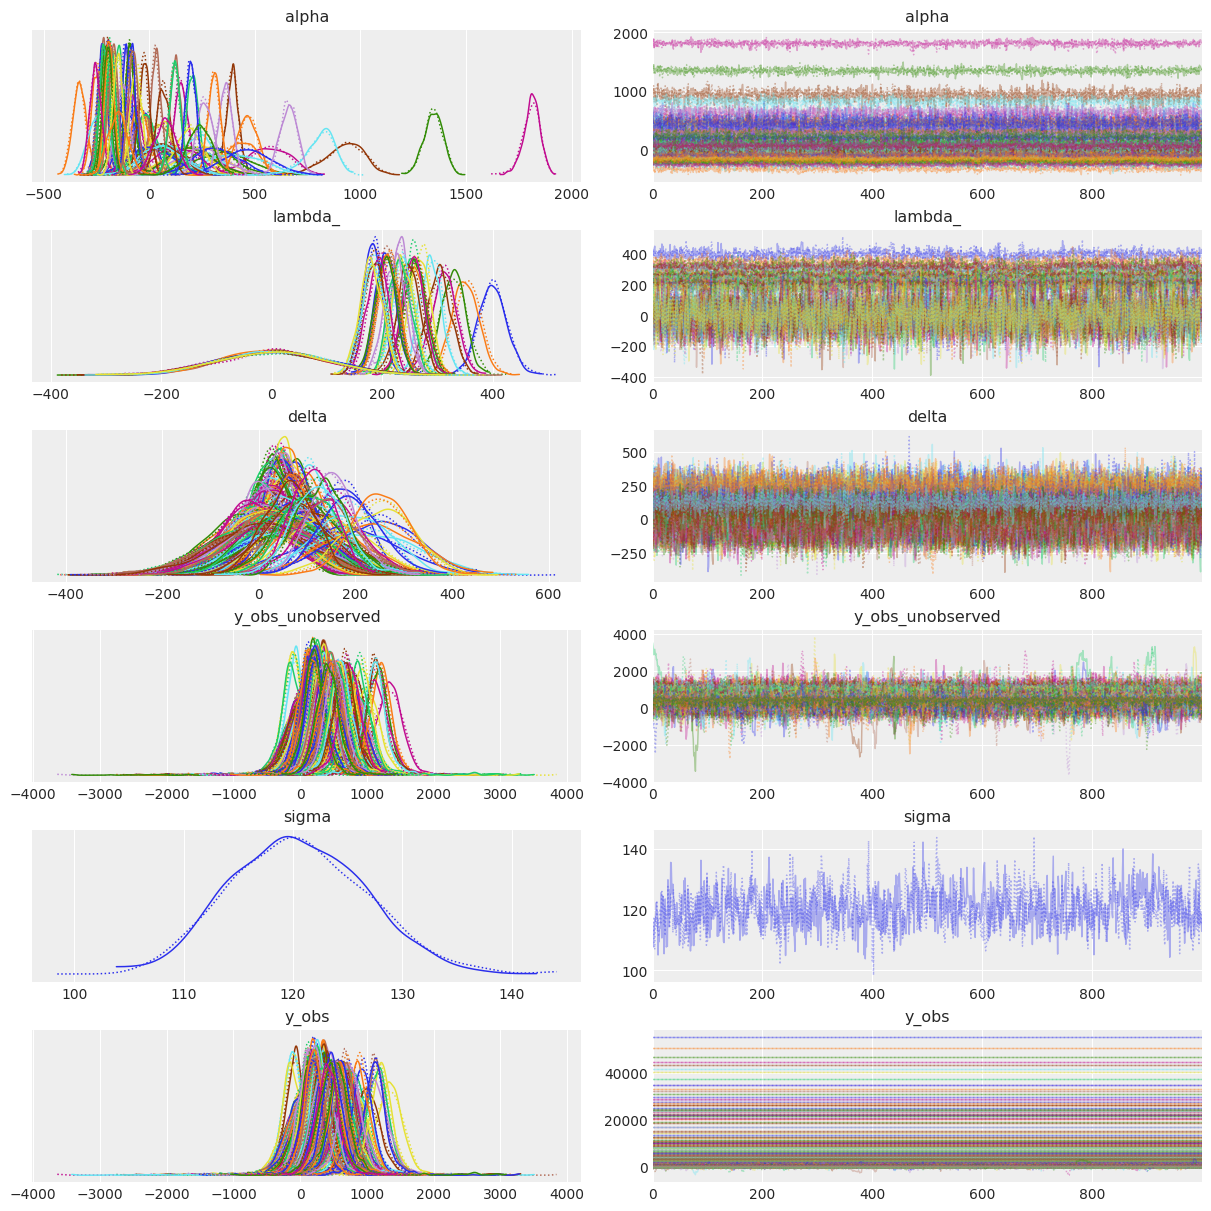

In [12]:
az.plot_trace(trace_dynamic_twfe);

In [142]:
delta_df = az.summary(trace_dynamic_twfe, var_names=['delta'], hdi_prob=0.95, kind='stats')
# pattern = re.compile(r'\d+')
# delta_df['index_number'] = delta_df.index.to_series().apply(lambda x: int(pattern.search(x).group()))

# 経過年数
time_since_intervention_list = df['time_since_intervention'].unique()
time_since_intervention_df = pd.DataFrame(time_since_intervention_list, columns=['time_since_intervention'])

# デルタの値を経過年数と結合
# デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
delta_df.reset_index(drop=True, inplace=True)
delta_df = pd.concat([delta_df, time_since_intervention_df], axis=1)

In [143]:
delta_df

,mean,sd,hdi_2.5%,hdi_97.5%,time_since_intervention
0,168.244,52.598,68.994,271.152,-29
1,96.754,50.185,5.054,199.226,-24
2,77.774,45.199,-8.397,166.929,-19
3,30.947,48.793,-62.811,129.135,-14
4,34.132,53.396,-71.024,135.875,-9
...,...,...,...,...,...
131,251.106,61.249,129.842,366.148,58
132,128.752,50.802,33.297,230.075,63
133,111.274,43.894,27.507,196.781,68
134,64.196,51.089,-41.079,154.188,46


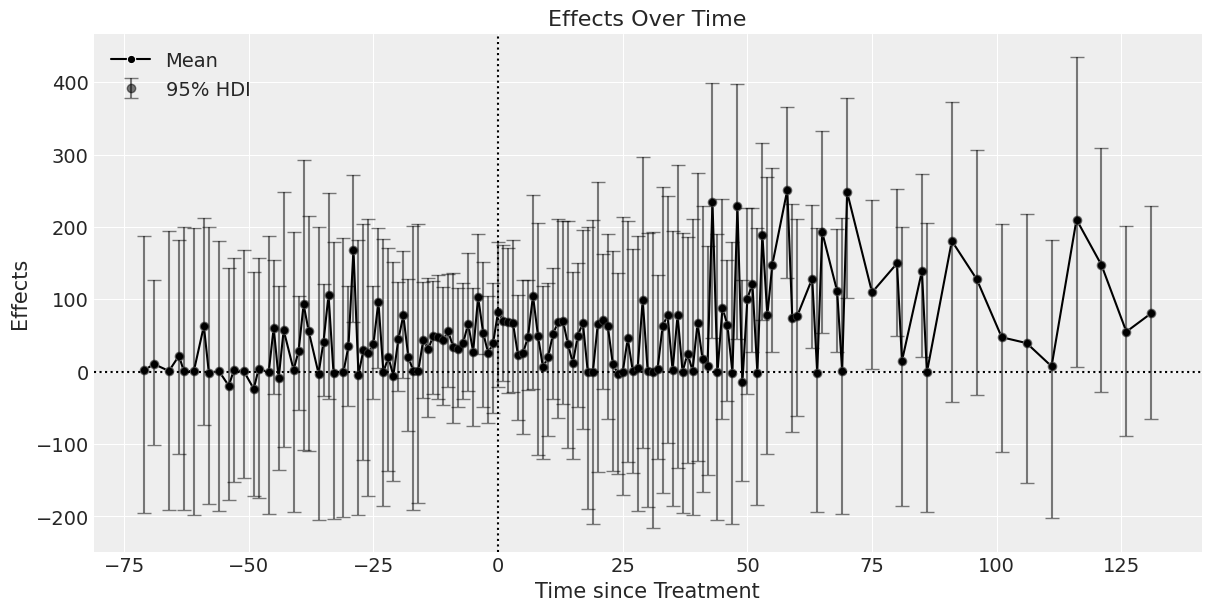

In [144]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='time_since_intervention',
    y='mean',
    data=delta_df,
    marker='o',
    color='black',
    label='Mean'
)
plt.errorbar(
    x=delta_df['time_since_intervention'],
    y=delta_df['mean'],
    yerr=[
        delta_df['mean'] - delta_df['hdi_2.5%'],
        delta_df['hdi_97.5%'] - delta_df['mean']
    ],
    fmt='o',
    color='black',
    alpha=0.5,
    capsize=5,
    label='95% HDI'
)
plt.axvline(x=0, color='black', linestyle=':')
plt.axhline(y=0, color='black', linestyle=':')
plt.xlabel('Time since Treatment')
plt.ylabel('Effects')
plt.title('Effects Over Time')
plt.legend()
plt.show()

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


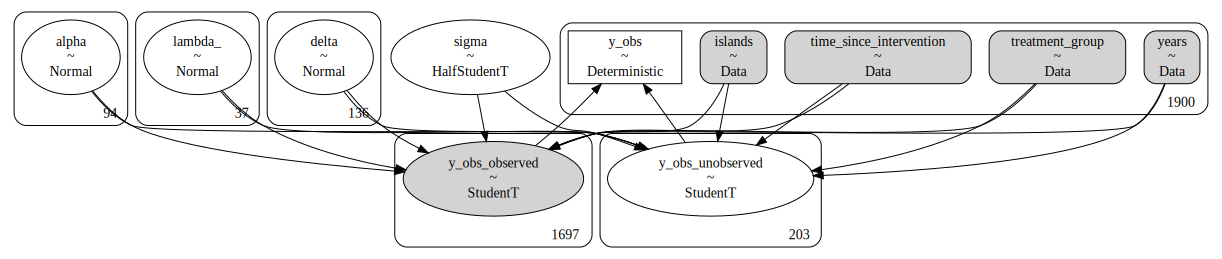

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfStudentT('sigma_alpha', nu=3, sigma=100)
    z_alpha = pm.Normal('z_alpha', mu=0, sigma=1, shape=len(df['island_ids'].unique()))
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * z_alpha)

    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfStudentT('sigma_lambda', nu=3, sigma=100)
    z_lambda = pm.Normal('z_lambda', mu=0, sigma=1, shape=len(df['years'].unique()))
    lambda_ = pm.Deterministic('lambda_', mu_lambda + sigma_lambda * z_lambda)

    delta = pm.Normal('delta', mu=0, sigma=100, shape=len(df['time_since_intervention'].unique()))
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta[time_since_intervention] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe_h)